In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_68k_Zheng\Zheng_PBMC.h5ad")
adata.shape

(68579, 32738)

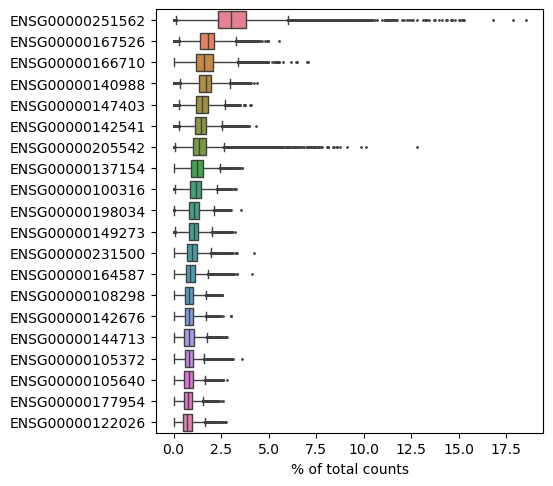

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

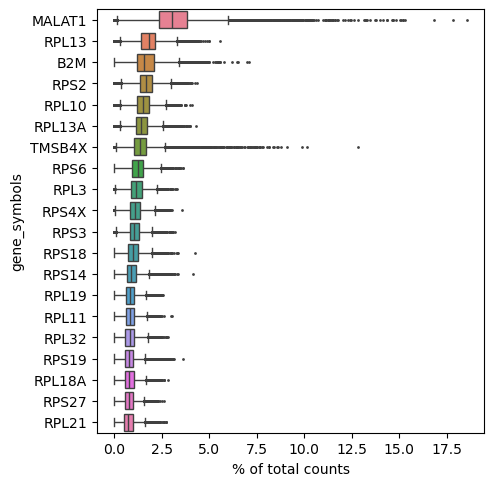

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_symbols')

## Quality control
(did not actually filter out cells)

In [ ]:
# Calculate quality control metrics
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var['gene_symbols'].str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [ ]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             stripplot=False, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [ ]:
# filtering out the low quality cells
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

## Normalization

In [7]:
# Normalization
# each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(adata, target_sum=None)
# log1p transformation
sc.pp.log1p(adata)

In [8]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression
# adata.raw = adata

## HVG

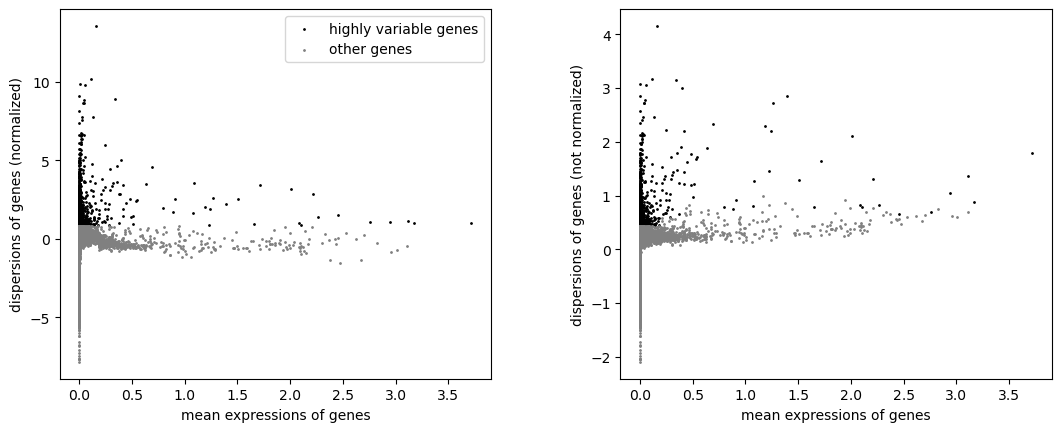

In [9]:
# HVG2000
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [10]:
adata.var.highly_variable.sum()

2000

In [11]:
# filtering HVG2000
adata = adata[:, adata.var.highly_variable]
adata.shape

(68579, 2000)

In [12]:
# regress out the unwanted sources of variation
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# Scale each gene to unit variance
# sc.pp.scale(adata, max_value=10)

## PCA

In [13]:
sc.tl.pca(adata, svd_solver="arpack")

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

## UMAP

In [21]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, metric='jaccard')

/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [22]:
adata.obsp

PairwiseArrays with keys: distances, connectivities

In [23]:
sc.tl.umap(adata)

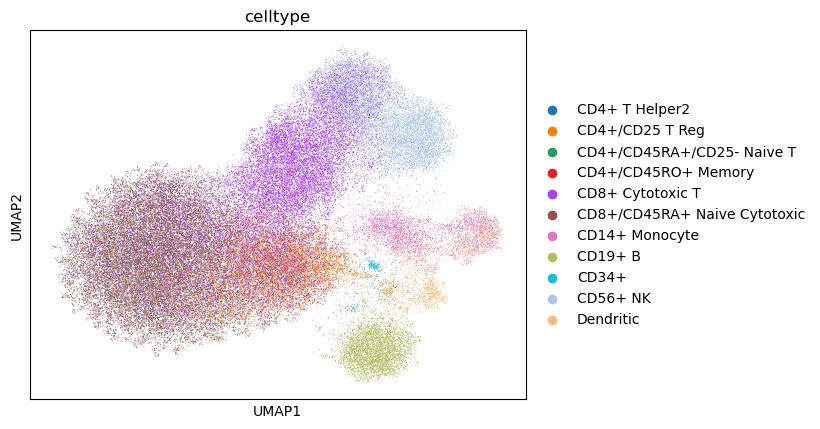

In [24]:
sc.pl.umap(adata, color='celltype')

## Leiden

In [27]:
sc.tl.leiden(adata, resolution=0.8)

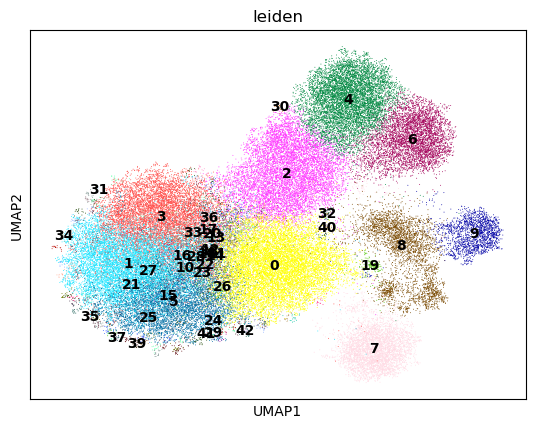

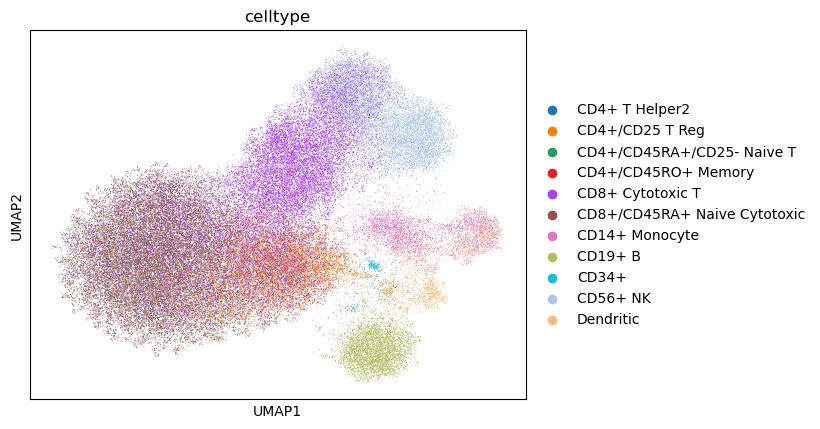

In [30]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', legend_loc='on data')
sc.pl.umap(adata, color='celltype', legend_loc='right margin')

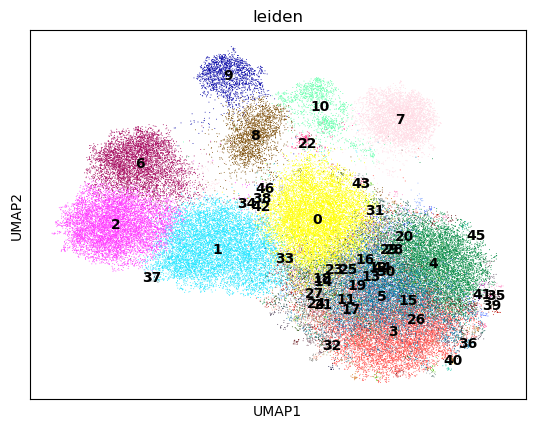

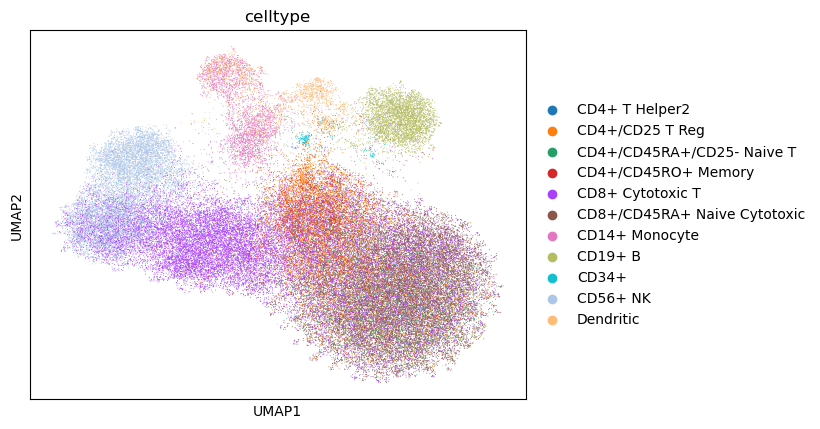

In [26]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color='leiden', legend_loc="on data")
sc.pl.umap(adata, color='celltype', legend_loc="right margin")

In [31]:
adata.obs['leiden'].unique()

['2', '3', '0', '7', '5', ..., '37', '41', '32', '30', '38']
Length: 43
Categories (43, object): ['0', '1', '2', '3', ..., '39', '40', '41', '42']

In [32]:
adata.obs.head()

,celltype,TSNE.1,TSNE.2,leiden
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,2
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,3
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,0
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,7
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,5


In [33]:
cluster_names = []
for i in adata.obs['leiden'].tolist():
    cluster_names.append('Leiden_' + str(i))

adata.obs['leiden_cluster'] = cluster_names
adata.obs.head()


,celltype,TSNE.1,TSNE.2,leiden,leiden_cluster
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,2,Leiden_2
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,3,Leiden_3
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,0,Leiden_0
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,7,Leiden_7
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,5,Leiden_5


In [34]:
adata.obs = adata.obs.drop('leiden', axis=1)
adata.obs.head()

,celltype,TSNE.1,TSNE.2,leiden_cluster
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,Leiden_2
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,Leiden_3
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,Leiden_0
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,Leiden_7
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,Leiden_5


In [35]:
adata.obs['leiden_cluster'].value_counts()

leiden_cluster
Leiden_0     10886
Leiden_1      9342
Leiden_2      8223
Leiden_3      7664
Leiden_4      7342
Leiden_5      6406
Leiden_6      4691
Leiden_7      4132
Leiden_8      3443
Leiden_9      1716
Leiden_10      436
Leiden_11      426
Leiden_12      420
Leiden_13      384
Leiden_14      363
Leiden_15      300
Leiden_16      290
Leiden_17      278
Leiden_18      275
Leiden_19      231
Leiden_20      221
Leiden_21      220
Leiden_22      210
Leiden_23      105
Leiden_24       91
Leiden_25       75
Leiden_26       65
Leiden_27       60
Leiden_28       52
Leiden_29       29
Leiden_34       16
Leiden_31       16
Leiden_30       16
Leiden_33       16
Leiden_36       16
Leiden_35       16
Leiden_32       16
Leiden_37       16
Leiden_41       15
Leiden_42       15
Leiden_39       15
Leiden_40       15
Leiden_38       15
Name: count, dtype: int64